In [ ]:
import lumicks.pylake as lk
import matplotlib.pyplot as plt
import glob
import numpy as np
%matplotlib widget

# AdK protein fitting

In this notebook, we are going to fit force-extension (force-distance) curves (F,d curves) of a protein attached to beads using DNA handles. Since these F,d curves were acquired in a situation where the traps were quite close together, the force signal has been affected by the trap-trap interaction and interaction of the bead with the other trap. Therefore, we corrected the force data using a background force curve that was acquired in the absence of a tether, using the same bead pair, pulling rate and range of trap movement. The data shown in this notebook has been corrected prior to its use in this notebook.

In [ ]:
def load_fd(measurement):
    file = lk.File(measurement)
    _, fd_curve = file.fdcurves.popitem()
    
    return fd_curve

### Selecting which data to fit

A frequent task when analyzing F,d curves is to divide the data into different relevant parts prior to fitting. To help with this, pylake ships with a small widget that allows you to select data ranges. This widget requires as input a set of F,d curves.

In [ ]:
fdcurves = {}
for filename in glob.glob('Data/*.h5'):
    file = lk.File(filename)
    key, curve = file.fdcurves.popitem()
    fdcurves[key] = curve

directory = 'Data/'
fdcurves = {"experiment 1": load_fd("Data/adk5_curve1.h5"),
            "experiment 2": load_fd("Data/adk5_curve2.h5"),
            "experiment 3": load_fd("Data/adk5_curve3.h5")}

### Selecting the data ranges for the folded and unfolded state

For our data here, we have three F, d curves. Let's plot the force over time and select which time ranges to use for fitting. Proceed by using the widget to select in each curve the region where the protein is still folded, and a region where the protein is unfolded. Your selection should look something like this:

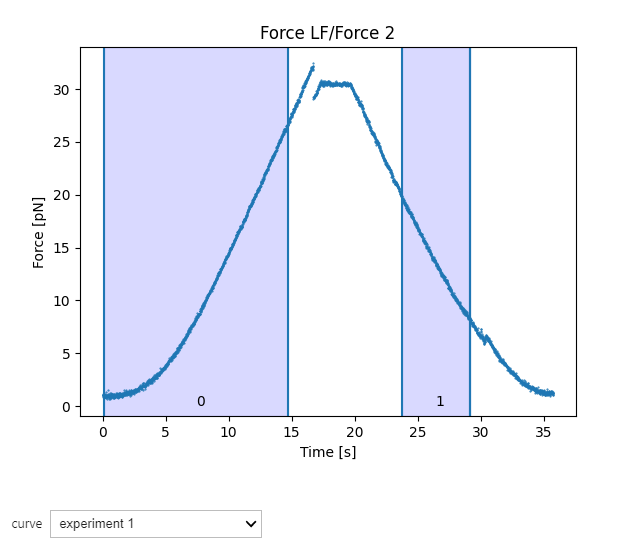

You can select a region by clicking its left bound, and then its right bound. Please be careful to select in each curve first the region where protein is folded. You can remove a selection by clicking it with the right mouse button:

In [ ]:
selector = lk.FdRangeSelector(fdcurves)
plt.show()

### Models used for fitting

In this notebook we're going to fit a composite model. First we will fit the part of the curve where the protein is still folded using an Odijk model with the parameters for DNA handles.
When the protein is folded, the elastic response we see is purely the response of the DNA handles.
The Odijk model is a so-called extensible worm-like chain model.
The term "extensible" refers to the fact that it can capture the enthalpic regime at higher forces (10 - 30 pN).
You can view the model by invoking `lk.ewlc_odijk_distance("dna_handles")` (for more information on this model, please see the literature references in the function description).

In [ ]:
lk.ewlc_odijk_distance("dna_handles")

The equation for the Odijk model is given by distance as a function of force:

$\begin{equation*}
d(F) = Lc \left(1 - \frac{1}{2}\sqrt{\frac{kT}{F Lp}} + \frac{F}{St}\right)\tag{1}
\end{equation*}$

The second segment of data where the protein is unfolded will require a more complex model. Here we will use a composite model that consists of two models to describe the data. The first one is the worm-like chain model (Odijk model) for the DNA handles we fitted before. The second one is another worm-like chain model that describes the unfolded protein. We assume the protein segment to be quite stiff and will model it with the inextensible Marko Siggia model.

The equation for the inextensible Marko Siggia model is:

$\begin{equation*}
F\left(d\right) = \frac{kT}{Lp} \left(\frac{1}{4} \left(1-\frac{d}{Lc}\right)^{-2} + \frac{d}{Lc} - \frac{1}{4}\right)\tag{2}
\end{equation*}$

The total length of the construct $d_{total}$ can be described as a sum of the length of the handles $d_{dna\_handles}$ and the protein length $d_{protein}$, since the DNA handles and protein are linked in series:

$\begin{equation*}
d_{total}(F) = d_{dna\_handles}(F) + d_{protein}(F)\tag{3}
\end{equation*}$

Note that this is different from adding them by force!

(1) For the first fit - fitting the DNA handles only, we wish to fit this model with force as a function of distance rather than vice versa (analogously to [1]). 

As the Odijk model is defined as distance as a function of force (i.e. `distance = model(force)`, it needs to be inverted. One way to do this would be to call the `.invert()` function on it (i.e. `lk.ewlc_odijk_distance("dna_handles").invert()`). However, inversion in that manner is always done numerically, which can be slow. Fortunately, `pylake` comes with some pre-inverted models out of the box. For a single extensible worm-like-chain model pylake provides a pre-inverted model: [`lk.ewlc_odijk_force`](https://lumicks-pylake.readthedocs.io/en/stable/_api/lumicks.pylake.ewlc_odijk_force.html).

In [ ]:
# Model of the dna handles only.
dna_handles_model = lk.ewlc_odijk_force("dna_handles") + lk.force_offset("dna_handles")

The offset parameter `lk.force_offset("dna_handles")` is added to account for a small force offset.

(2) For the second fit - fitting the unfolded protein + DNA handles, we need to employ a composite model (sum of two worm-like chains), as described by formula above (2), and we would like to fit this composite model as force as a function of distance.

Formula (2), written in the code looks like: 


In [ ]:
# When using multiple models, we want to add them by distance, not force. Therefore, we add the models based on distance.
#  d_total = d_handle + d_protein
composite_model_as_function_of_force = lk.ewlc_odijk_distance("dna_handles") + lk.wlc_marko_siggia_distance("protein")

Considering that we want to express and fit the composite model as force as a function of distance, we have to invert the full composite model. Unfortunately, there is no closed form solution for this and we will have to resort to numerical methods to perform this inversion for us. This can be done by calling Pylake function [`invert()`](https://lumicks-pylake.readthedocs.io/en/stable/_api/lumicks.pylake.fitting.model.Model.html#lumicks.pylake.fitting.model.Model.invert) on the `composite_model_as_function_of_force`. It will however be quite slow, as it solves the equation for every data point at every fitting iteration. 

To speed up the process, we can use "inversion via interpolation". In this case, the `distance = function(force)` curve is interpolated and the interpolated curve is used to invert the model (similar to the approach in [1]). The "inversion via interpolation" method is selected by setting the parameter `interpolate = True` and providing a minimum and maximum value for the independent variable (in this case - $F$, force). Within these ranges, the model will be inverted numerically. The code for this operation looks like:

In [ ]:
# To obtain the model with force as a function of distance we invert it. We also include a force offset.
#  F = d_total.invert() + offset
composite_model = composite_model_as_function_of_force.invert(interpolate=True, independent_min=0, independent_max=90) + lk.force_offset("dna_handles")

### Preparing to fit the models

We want to fit both these models to data and want both of these to share parameters. We can easily do this using pylake by setting up an `FdFit` that includes both of them as follows:

In [ ]:
fit = lk.FdFit(dna_handles_model, composite_model)

### Adding data

In order to prevent the optimization procedure from getting lost and produce a poor fit and/or unphysical parameter estimates, fitting algorithms often require your initial guesses to not differ too much from the final solution.

Let's fit the model for DNA handles to the part of the data where the protein is folded first. The eWLC (extensible) model for only DNA handles is much simpler and it's a so-called analytical model, which means it'll be very fast. Having these parameter estimates in hand, they can then be used for the second fitting phase. Let's add some data to the fit. Note how we add data specifically to the `dna_handles_model`:

In [ ]:
for i, curve in enumerate(selector.fdcurves.values()):
    force_data = curve[0].f.data
    distance_data = curve[0].d.data
    fit[dna_handles_model].add_data(f"Closed dataset {i}", 
                                    force_data[distance_data > 0],
                                    distance_data[distance_data > 0])

It's usually a good idea to help your solver as much as you can. Try to provide good initial estimates and bounds when possible. These can come from literature, other studies or perhaps even experience.

If, after fitting you notice that your parameter estimates are bumping into the bounds, then it may be worth investigating whether your prior assumptions were wrong.

For this experiment, we know that we have a DNA handles size of about 1040 base pairs of about 0.34 nm for each base pair. That amounts to roughly .35 microns of DNA. The length deduced from the known number of base pairs in the DNA handles provides a good initial estimate of `Lc` (contour length of the DNA handles). We based our initial guesses for the persistence length and elastic stretch modulus on the results of similar protein folding experiments and set these to 15 nm and 350 pN respectively, as described in the literature [2].

After providing these estimates, we can fit our data.

In [ ]:
fit["dna_handles/Lc"].value = .35
fit["dna_handles/Lp"].value = 15
fit["dna_handles/St"].value = 300
fit["dna_handles/St"].lower_bound = 250
fit["dna_handles/f_offset"].upper_bound = 6
fit["dna_handles/f_offset"].lower_bound = -6

fit.fit()
fit

Let's have a peek at the fit of the first part of the data, where the protein was still folded: the elastic response of the DNA-protein tether is purely defined by double-stranded DNA:

In [ ]:
plt.figure()
fit[dna_handles_model].plot()
plt.ylabel('Force [pN]')
plt.xlabel(r'Distance [$\mu$m]')
plt.show()

This fit looks good. Time to fit the part of the data where the protein is unfolded. In the next code block, we add the data for the unfolded protein to the fit. Note how we add it to the `composite_model` specifically:

In [ ]:
for i, curve in enumerate(selector.fdcurves.values()):
    force_data = curve[1].f.data
    distance_data = curve[1].d.data
    fit[composite_model].add_data(f"Open dataset {i}",
                                  force_data[distance_data > 0],
                                  distance_data[distance_data > 0]
                                  )

Again, we need to put some initial guesses for the fit. We know the protein is going to be relatively short so we make a rough estimate of the order of magnitude. In general, the expected length of your fully unfolded protein can be calculated as the number of amino acids in the polypeptide chain multiplied by 0.356 nm per amino acid.

We also know that the persistence length of proteins is generally a lot lower than that of dsDNA. Therefore, we provide some rough bounds based on [2].

These fits share parameters - essentially, the composite_model will be the sum of the WLC for protein and the WLC for the DNA handles. Considering that these fits share parameters, we already have good parameter values for the DNA part and fix these:

In [ ]:
fit["protein/Lp"].value = .7
fit["protein/Lp"].lower_bound = .6
fit["protein/Lp"].upper_bound = 1.0
fit["protein/Lp"].fixed = False
fit["protein/Lc"].value = .01

fit["dna_handles/St"].fixed = True
fit["dna_handles/Lp"].fixed = True
fit["dna_handles/Lc"].fixed = True

In [ ]:
fit.fit();

In [ ]:
plt.figure()
fit[dna_handles_model].plot()
fit[composite_model].plot(independent=np.arange(.26, .4, .001))
plt.ylabel('Force [pN]')
plt.xlabel(r'Distance [$\mu$m]')
plt.show()
fit

### Conclusion

If all went well, you should now be able to observe an estimated contour length of approximately 25 nm for the protein (variable `protein/Lc`).

This value can be used to obtain which fraction of the protein got unfolded (in terms of number of amino acids) by dividing it by 0.356nm/amino acid.

The obtained contour length corresponds to the actual increase of distance (tether length) caused by the protein domain(s) that have been unfolded.

# References

[1] Broekmans, O. D., King, G. A., Stephens, G. J., & Wuite, G. J. (2016). DNA twist stability changes with magnesium (2+) concentration. Physical review letters, 116(25), 258102.

[2] Jahn, M., Buchner, J., Hugel, T., & Rief, M. (2016). Folding and assembly of the large molecular machine Hsp90 studied in single-molecule experiments. Proceedings of the National Academy of Sciences, 113(5), 1232-1237.